Import Data dan Library

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

Load Data

In [58]:
file_path = 'track_data_final.csv'
df_spotify = pd.read_csv(file_path)
df_spotify.head()

,track_id,track_name,track_number,track_popularity,track_duration_ms,explicit,artist_name,artist_popularity,artist_followers,artist_genres,album_id,album_name,album_release_date,album_total_tracks,album_type
0,6pymOcrCnMuCWdgGVTvUgP,3,57,61,213173,False,Britney Spears,80.0,17755451.0,['pop'],325wcm5wMnlfjmKZ8PXIIn,The Singles Collection,2009-11-09,58,compilation
1,2lWc1iJlz2NVcStV5fbtPG,Clouds,1,67,158760,False,BUNT.,69.0,293734.0,['stutter house'],2ArRQNLxf9t0O0gvmG5Vsj,Clouds,2023-01-13,1,single
2,1msEuwSBneBKpVCZQcFTsU,Forever & Always (Taylor’s Version),11,63,225328,False,Taylor Swift,100.0,145396321.0,[],4hDok0OAJd57SGIT8xuWJH,Fearless (Taylor's Version),2021-04-09,26,album
3,7bcy34fBT2ap1L4bfPsl9q,I Didn't Change My Number,2,72,158463,True,Billie Eilish,90.0,118692183.0,[],0JGOiO34nwfUdDrD612dOp,Happier Than Ever,2021-07-30,16,album
4,0GLfodYacy3BJE7AI3A8en,Man Down,7,57,267013,False,Rihanna,90.0,68997177.0,[],5QG3tjE5L9F6O2vCAPph38,Loud,2010-01-01,13,album


In [59]:
print("Jumlah baris, kolom:", df_spotify.shape)
print("\nTipe data:")
print(df_spotify.dtypes)

Jumlah baris, kolom: (8778, 15)

Tipe data:
track_id               object
track_name             object
track_number            int64
track_popularity        int64
track_duration_ms       int64
explicit                 bool
artist_name            object
artist_popularity     float64
artist_followers      float64
artist_genres          object
album_id               object
album_name             object
album_release_date     object
album_total_tracks      int64
album_type             object
dtype: object


Pembersihan Data

Cek dan Menangani Missing Value

In [60]:
# Cek ukuran awal
print("Dimensi awal:", df_spotify.shape)

# Cek missing value
print("\nMissing value per kolom:")
print(df_spotify.isnull().sum())

Dimensi awal: (8778, 15)

Missing value per kolom:
track_id              0
track_name            2
track_number          0
track_popularity      0
track_duration_ms     0
explicit              0
artist_name           4
artist_popularity     4
artist_followers      4
artist_genres         4
album_id              0
album_name            2
album_release_date    0
album_total_tracks    0
album_type            0
dtype: int64


Cek dan Hapus Duplikat

In [61]:
# Hapus kolom tidak relevan
cols_to_drop = [
    'track_id', 'track_name', 'artist_name',
    'artist_genres', 'album_id', 'album_name'
]

df_spotify = df_spotify.drop(columns=cols_to_drop)

# Hapus baris dengan missing value
df_spotify = df_spotify.dropna()

print("\nDimensi setelah cleaning:", df_spotify.shape)


Dimensi setelah cleaning: (8774, 9)


Ubah ke Numerik

In [62]:
# Ubah Boolean (True/False) ke Angka (1/0)
df_spotify['explicit'] = df_spotify['explicit'].astype(int)

# Ambil tahun rilis dari tanggal
df_spotify['release_year'] = pd.to_datetime(
    df_spotify['album_release_date'], errors='coerce'
).dt.year

# Hapus kolom tanggal asli
df_spotify = df_spotify.drop(columns=['album_release_date'])

# Drop NA hasil konversi tanggal
df_spotify = df_spotify.dropna()

# One-Hot Encoding kolom kategorikal
df_spotify = pd.get_dummies(
    df_spotify,
    columns=['album_type'],
    drop_first=True
)

print("\n=== DATA SIAP TRAINING ===")
print("Dimensi akhir:", df_spotify.shape)
df_spotify.head()


=== DATA SIAP TRAINING ===
Dimensi akhir: (8573, 10)


,track_number,track_popularity,track_duration_ms,explicit,artist_popularity,artist_followers,album_total_tracks,release_year,album_type_compilation,album_type_single
0,57,61,213173,0,80.0,17755451.0,58,2009.0,True,False
1,1,67,158760,0,69.0,293734.0,1,2023.0,False,True
2,11,63,225328,0,100.0,145396321.0,26,2021.0,False,False
3,2,72,158463,1,90.0,118692183.0,16,2021.0,False,False
4,7,57,267013,0,90.0,68997177.0,13,2010.0,False,False


Pemisahan Fitur Target dan Train Test Split

In [63]:
# Tentukan Fitur (X) dan Target (y)
target = 'track_popularity'
X = df_spotify.drop(columns=[target])
y = df_spotify[target]

# Split Data (80:20) dengan Random State 28
# (Sesuai instruksi: 2 digit terakhir NPM)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28
)

print(f"Jumlah Data Training: {X_train.shape[0]}")
print(f"Jumlah Data Testing : {X_test.shape[0]}")

Jumlah Data Training: 6858
Jumlah Data Testing : 1715


Standard Scaler

In [64]:
print("=== HASIL DENGAN STANDARD SCALER ===")

# 1. Scaling (Standardisasi)
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# 2. Model Ridge (L2 Regularization)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_std, y_train)
y_pred_ridge = ridge.predict(X_test_std)

# 3. Model Lasso (L1 Regularization)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_std, y_train)
y_pred_lasso = lasso.predict(X_test_std)

# Evaluasi
print(f"[Ridge] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}, R2: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"[Lasso] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.4f}, R2: {r2_score(y_test, y_pred_lasso):.4f}")

=== HASIL DENGAN STANDARD SCALER ===
[Ridge] RMSE: 20.9049, R2: 0.2607
[Lasso] RMSE: 20.9038, R2: 0.2608


Minmax Scaler

In [65]:
print("=== HASIL DENGAN MINMAX SCALER ===")

# 1. Scaling (Normalisasi 0-1)
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

# 2. Model Ridge
ridge_mm = Ridge(alpha=1.0)
ridge_mm.fit(X_train_mm, y_train)
y_pred_ridge_mm = ridge_mm.predict(X_test_mm)

# 3. Model Lasso
lasso_mm = Lasso(alpha=0.1)
lasso_mm.fit(X_train_mm, y_train)
y_pred_lasso_mm = lasso_mm.predict(X_test_mm)

# Evaluasi
print(f"[Ridge] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge_mm)):.4f}, R2: {r2_score(y_test, y_pred_ridge_mm):.4f}")
print(f"[Lasso] RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso_mm)):.4f}, R2: {r2_score(y_test, y_pred_lasso_mm):.4f}")

=== HASIL DENGAN MINMAX SCALER ===
[Ridge] RMSE: 20.9040, R2: 0.2608
[Lasso] RMSE: 21.0106, R2: 0.2532


Pipeline Ridge Regression

In [66]:
print("=== PIPELINE RIDGE REGRESSION ===")

n_features = X_train.shape[1]

# 1. Pipeline
pipe_ridge = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('model', Ridge())
])

# 2. Parameter Grid
param_grid_ridge = [
    {
        'feature_selection': [SelectKBest(f_regression)],
        'feature_selection__k': [5, n_features],
        'model__alpha': [0.1, 1.0]
    },
    {
        'feature_selection': [SelectPercentile(f_regression)],
        'feature_selection__percentile': [25, 50],
        'model__alpha': [0.1, 1.0]
    }
]

# 3. GridSearch
grid_ridge = GridSearchCV(
    pipe_ridge,
    param_grid_ridge,
    cv=5,
    scoring='r2'
)

grid_ridge.fit(X_train, y_train)

# 4. Ambil model terbaik
best_ridge = grid_ridge.best_estimator_

# 5. Evaluasi
y_pred = best_ridge.predict(X_test)

print("Best Params:", grid_ridge.best_params_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

=== PIPELINE RIDGE REGRESSION ===
Best Params: {'feature_selection': SelectKBest(score_func=<function f_regression at 0x0000015655281B20>), 'feature_selection__k': 9, 'model__alpha': 0.1}
RMSE: 20.904765432473148
R2: 0.26074810535801785


Pipeline Lasso Regression

In [67]:
print("=== PIPELINE LASSO REGRESSION ===")

n_features = X_train.shape[1]

# 1. Pipeline
pipe_lasso = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectKBest(f_regression)),
    ('model', Lasso(max_iter=5000))
])

# 2. Parameter Grid
param_grid_lasso = [
    {
        'feature_selection': [SelectKBest(f_regression)],
        'feature_selection__k': [5, n_features],
        'model__alpha': [0.01, 0.1, 1.0]
    },
    {
        'feature_selection': [SelectPercentile(f_regression)],
        'feature_selection__percentile': [25, 50],
        'model__alpha': [0.01, 0.1, 1.0]
    }
]

# 3. GridSearch
grid_lasso = GridSearchCV(
    pipe_lasso,
    param_grid_lasso,
    cv=5,
    scoring='r2'
)

grid_lasso.fit(X_train, y_train)

# 4. Ambil model terbaik
best_lasso = grid_lasso.best_estimator_

# 5. Evaluasi
y_pred = best_lasso.predict(X_test)

print("Best Params:", grid_lasso.best_params_)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

=== PIPELINE LASSO REGRESSION ===
Best Params: {'feature_selection': SelectKBest(score_func=<function f_regression at 0x0000015655281B20>), 'feature_selection__k': 9, 'model__alpha': 0.01}
RMSE: 20.903138907940157
R2: 0.2608631379393621


GridSearchCV

In [68]:
pipe_lasso = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('model', Lasso(random_state=28, max_iter=5000))
])

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression

param_grid_lasso = [
    # Lasso
    {
        'feature_selection': [None],
        'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
    },
    
    # SelectKBest
    {
        'feature_selection': [SelectKBest(score_func=f_regression)],
        'feature_selection__k': [5, 10, 15, 20], 
        'model__alpha': [0.01, 0.1, 1.0] 
    },
    
    # SelectPercentile
    {
        'feature_selection': [SelectPercentile(score_func=f_regression)],
        'feature_selection__percentile': [25, 50, 75], 
        'model__alpha': [0.01, 0.1, 1.0] 
    }
]

In [69]:
# Inisialisasi GridSearch
grid_lasso = GridSearchCV(
    estimator=pipe_lasso,
    param_grid=param_grid_lasso,
    cv=5,                 # 5-fold cross-validation
    scoring='r2',         # Gunakan R-squared untuk membandingkan model
    n_jobs=-1             # Menggunakan semua core CPU untuk komputasi paralel
)

print("Memulai proses fitting GridSearchCV...")
start_time = time.time()

# Latih Grid Search pada data latih
grid_lasso.fit(X_train, y_train)

end_time = time.time()
print(f"Proses fitting selesai dalam {end_time - start_time:.2f} detik.")

# --- HASIL DAN EVALUASI ---
best_lasso = grid_lasso.best_estimator_
y_pred = best_lasso.predict(X_test)

print("\n--- Hasil GridSearchCV dan Evaluasi Model Terbaik ---")
print(f"Best R2 Score (Cross-Validation): {grid_lasso.best_score_:.4f}")
print("Best Params:", grid_lasso.best_params_)

# Hitung Metrik Evaluasi pada Test Set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE) pada Test Set: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) pada Test Set: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) pada Test Set: {mae:.4f}")
print(f"R-squared (R2 Score) pada Test Set: {r2:.4f}")

Memulai proses fitting GridSearchCV...
Proses fitting selesai dalam 0.38 detik.

--- Hasil GridSearchCV dan Evaluasi Model Terbaik ---
Best R2 Score (Cross-Validation): 0.2477
Best Params: {'feature_selection': None, 'model__alpha': 0.001}

Mean Squared Error (MSE) pada Test Set: 437.0145
Root Mean Squared Error (RMSE) pada Test Set: 20.9049
Mean Absolute Error (MAE) pada Test Set: 15.8236
R-squared (R2 Score) pada Test Set: 0.2607


Scatterplot Matrix

Fitur: ['artist_popularity', 'artist_followers', 'album_type_single', 'explicit', 'album_type_compilation', 'track_duration_ms']


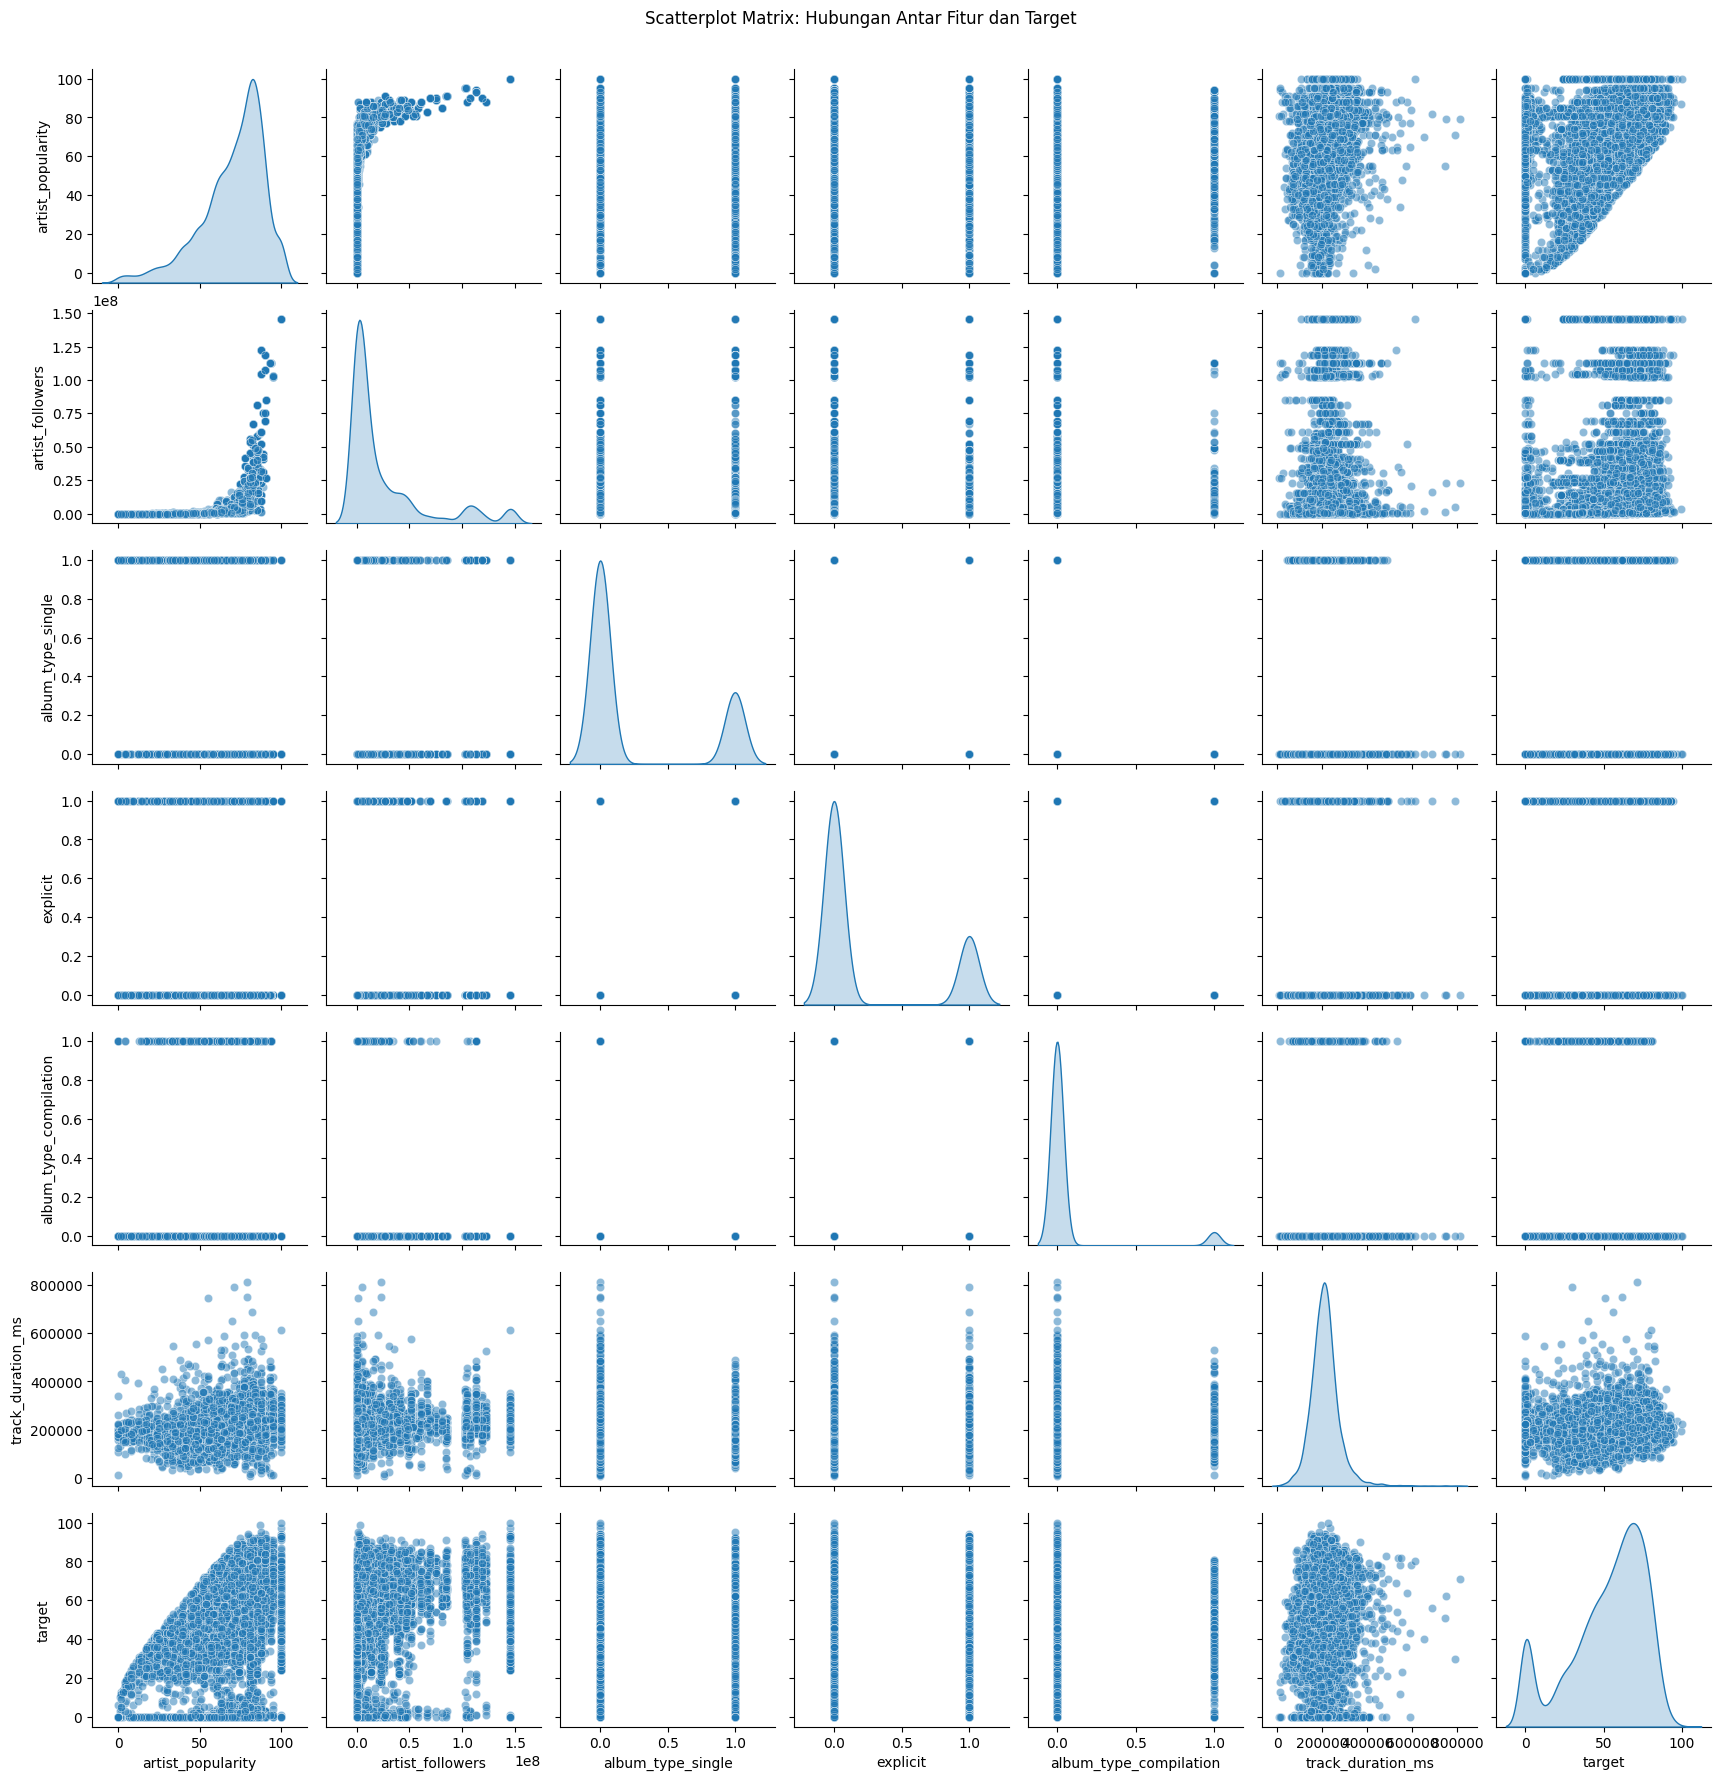

In [70]:
# Konversi X_train ke DataFrame dengan nama kolom asli
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Pilih beberapa fitur penting untuk visualisasi (agar tidak terlalu padat)
if X_train_df.shape[1] > 6:
    # Gunakan korelasi untuk pilih fitur terpenting
    corr_matrix = X_train_df.corrwith(pd.Series(y_train.values, index=X_train_df.index)).abs()
    top_features = corr_matrix.nlargest(6).index.tolist()
    X_vis = X_train_df[top_features[:6]]
else:
    X_vis = X_train_df

# Tambahkan target untuk scatter matrix
df_vis = X_vis.copy()
df_vis['target'] = y_train.values

print(f"Fitur: {list(X_vis.columns)}")

# Buat scatter matrix
sns.pairplot(df_vis, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Scatterplot Matrix: Hubungan Antar Fitur dan Target', y=1.02)
plt.show()

Plot Residual Training dan Test Data Untuk Setiap Model

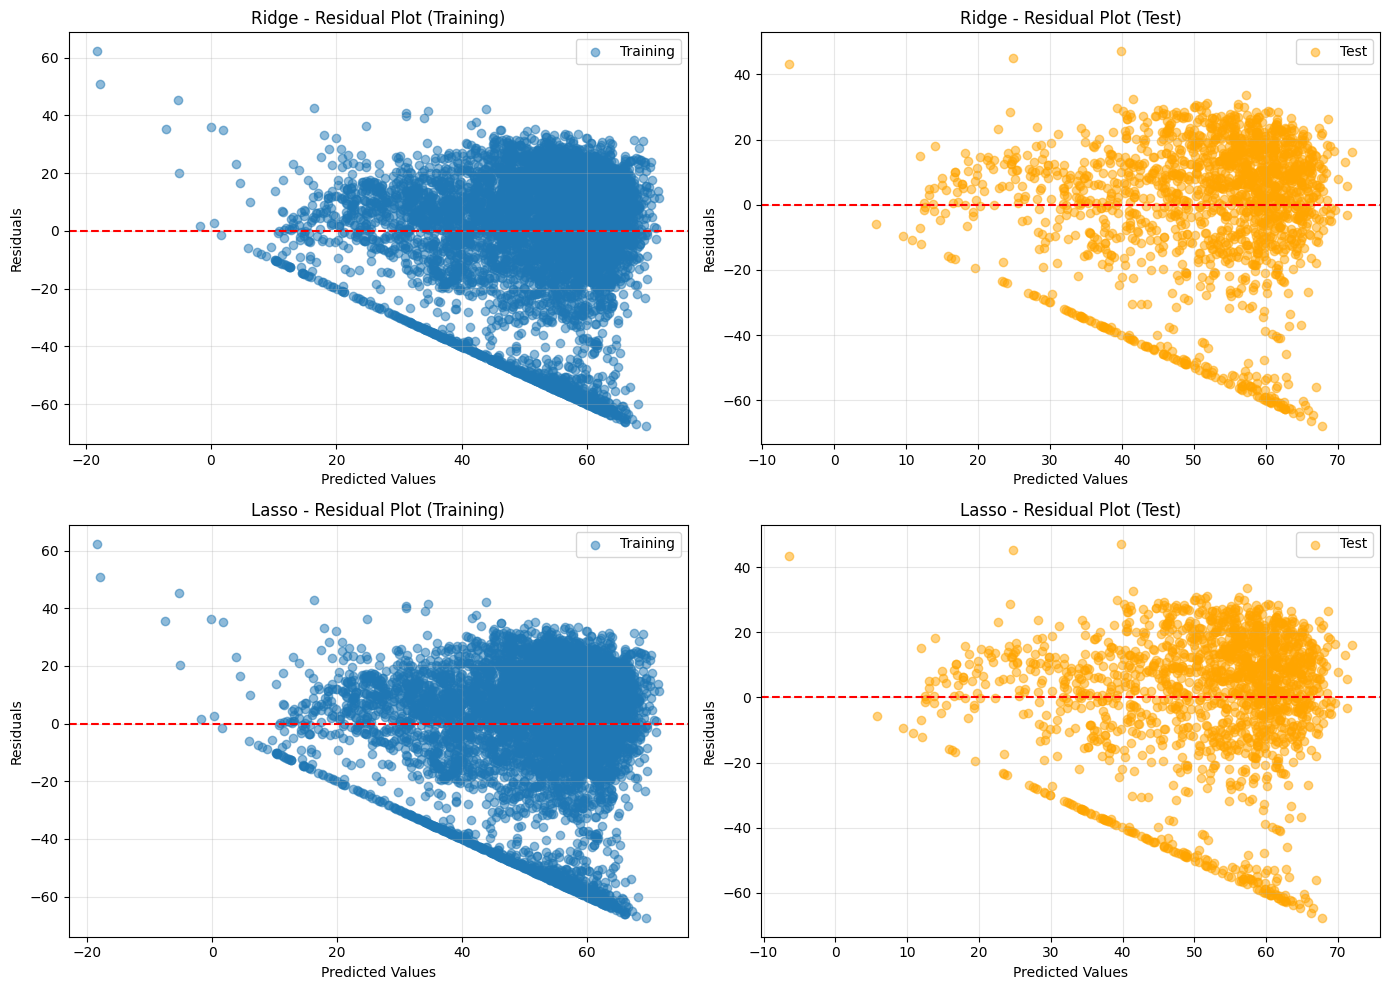

In [71]:
models = {
    'Ridge': best_ridge,
    'Lasso': best_lasso
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    # Prediksi untuk training dan test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Residual
    residuals_train = y_train - y_pred_train
    residuals_test = y_test - y_pred_test
    
    # Plot residual training
    axes[idx*2].scatter(y_pred_train, residuals_train, alpha=0.5, label='Training')
    axes[idx*2].axhline(y=0, color='r', linestyle='--')
    axes[idx*2].set_xlabel('Predicted Values')
    axes[idx*2].set_ylabel('Residuals')
    axes[idx*2].set_title(f'{name} - Residual Plot (Training)')
    axes[idx*2].legend()
    axes[idx*2].grid(True, alpha=0.3)
    
    # Plot residual test
    axes[idx*2+1].scatter(y_pred_test, residuals_test, alpha=0.5, label='Test', color='orange')
    axes[idx*2+1].axhline(y=0, color='r', linestyle='--')
    axes[idx*2+1].set_xlabel('Predicted Values')
    axes[idx*2+1].set_ylabel('Residuals')
    axes[idx*2+1].set_title(f'{name} - Residual Plot (Test)')
    axes[idx*2+1].legend()
    axes[idx*2+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Plot antara Fitur dan Target Untuk Setiap Model Pada Training Data

4 fitur dengan korelasi tertinggi: ['artist_popularity', 'artist_followers', 'album_type_single', 'explicit']


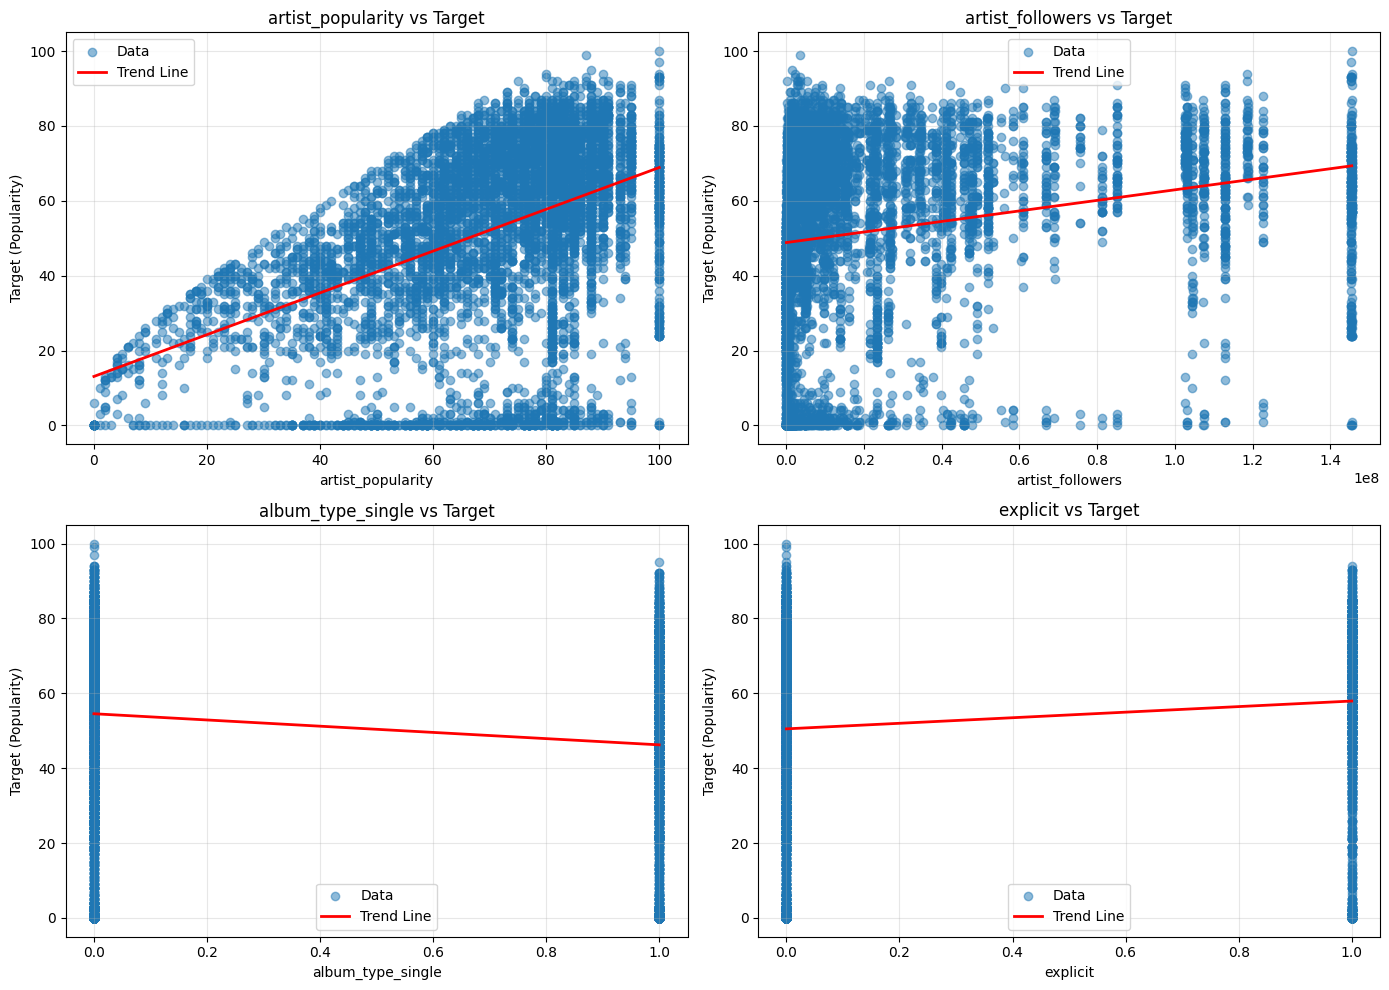

In [72]:
# Konversi X_train ke DataFrame
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Hitung korelasi dengan target
correlations = X_train_df.corrwith(pd.Series(y_train.values, index=X_train_df.index)).abs()
top_4_features = correlations.nlargest(4).index.tolist()

print(f"4 fitur dengan korelasi tertinggi: {top_4_features}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat_name in enumerate(top_4_features):
    # Scatter plot - AKSES dengan NAMA kolom, bukan indeks
    axes[i].scatter(X_train_df[feat_name], y_train, alpha=0.5, label='Data')
    
    # Tambahkan garis regresi
    x_vals = X_train_df[feat_name]
    
    # Regresi linear sederhana
    coeffs = np.polyfit(x_vals, y_train, 1)
    poly = np.poly1d(coeffs)
    x_range = np.linspace(x_vals.min(), x_vals.max(), 100)
    axes[i].plot(x_range, poly(x_range), color='red', linewidth=2, label='Trend Line')
    
    axes[i].set_xlabel(feat_name)
    axes[i].set_ylabel('Target (Popularity)')
    axes[i].set_title(f'{feat_name} vs Target')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Prediksi vs Aktual

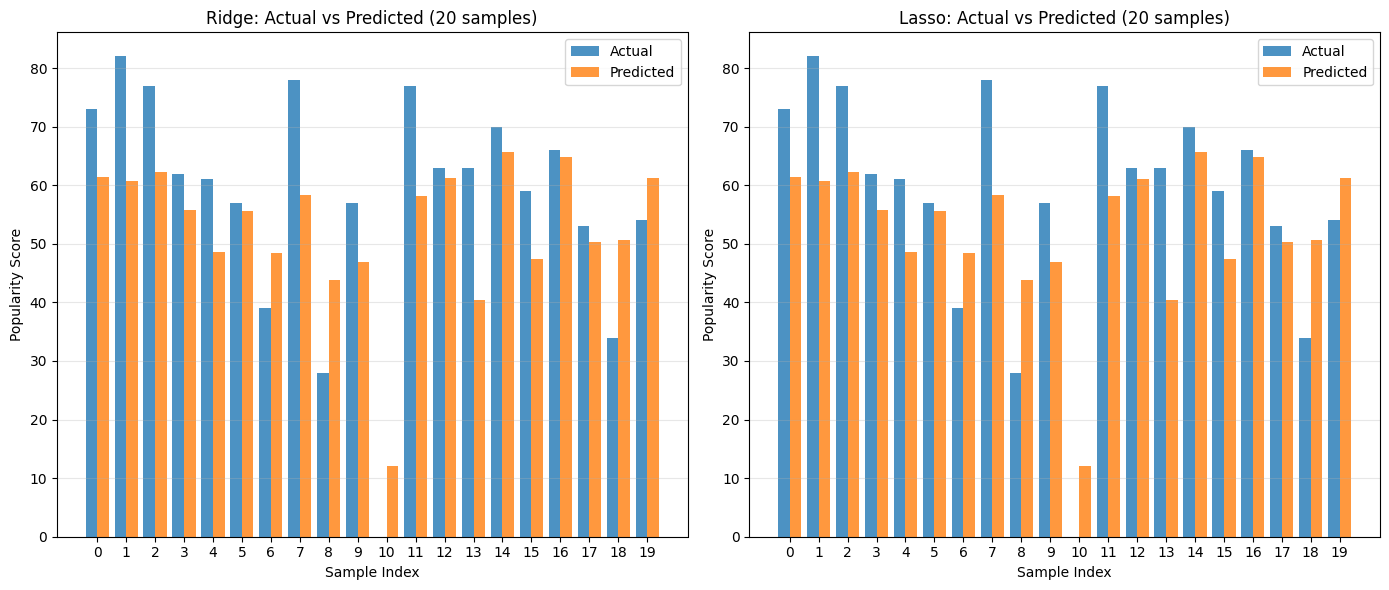

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ambil 20 sampel pertama
sample_indices = range(min(20, len(X_test)))

for idx, (name, model) in enumerate(models.items()):
    # Prediksi untuk 20 sampel pertama
    X_sample = X_test.iloc[sample_indices] if hasattr(X_test, 'iloc') else X_test[sample_indices]
    y_true_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]
    y_pred_sample = model.predict(X_sample)
    
    # Buat dataframe untuk plotting
    df_compare = pd.DataFrame({
        'Actual': y_true_sample,
        'Predicted': y_pred_sample,
        'Sample': list(sample_indices)
    })
    
    # Plot bar chart
    x_pos = np.arange(len(df_compare))
    axes[idx].bar(x_pos - 0.2, df_compare['Actual'], width=0.4, label='Actual', alpha=0.8)
    axes[idx].bar(x_pos + 0.2, df_compare['Predicted'], width=0.4, label='Predicted', alpha=0.8)
    
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Popularity Score')
    axes[idx].set_title(f'{name}: Actual vs Predicted (20 samples)')
    axes[idx].set_xticks(x_pos)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Mengambil Model Terbaik

In [77]:
best_lasso_pipeline = grid_lasso.best_estimator_
best_params = grid_lasso.best_params_
best_cv_score = grid_lasso.best_score_

# Prediksi pada Test Set
y_pred_best = best_lasso_pipeline.predict(X_test)

# Hitung Metrik Evaluasi Akhir
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f"Algoritma: Lasso Regression (dalam Pipeline)")
print(f"Parameter Terbaik: {best_params}")
print(f"R2 Score (Cross-Validation Terbaik): {best_cv_score:.4f}")
print("-" * 50)
print("Metrik Evaluasi pada TEST SET:")
print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Algoritma: Lasso Regression (dalam Pipeline)
Parameter Terbaik: {'feature_selection': None, 'model__alpha': 0.001}
R2 Score (Cross-Validation Terbaik): 0.2477
--------------------------------------------------
Metrik Evaluasi pada TEST SET:
R-squared (R2): 0.2607
Root Mean Squared Error (RMSE): 20.9049
Mean Squared Error (MSE): 437.0145
Mean Absolute Error (MAE): 15.8236


Export Pickle

In [75]:
import pickle

# Simpan model Lasso Regression yang sudah dilatih ke file .pkl (format biner)
with open('notebook1_best_model.pkl', 'wb') as f:
    pickle.dump(best_lasso_pipeline, f)
# Konfirmasi bahwa model berhasil disimpan
print(" Model Lasso Regression berhasil disimpan ke notebook1_best_model.pkl")

 Model Lasso Regression berhasil disimpan ke notebook1_best_model.pkl
